In [3]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import warnings

warnings.filterwarnings("ignore")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
def data_loader(batch_size):

  kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])  # https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151
  
  trainloader = torch.utils.data.DataLoader\
  (torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform), batch_size=batch_size ,shuffle=True, **kwargs)
  testloader = torch.utils.data.DataLoader\
  (torchvision.datasets.CIFAR10(root='./data', train=False,download=True,transform=transform), batch_size=batch_size,shuffle=False, **kwargs)
  return trainloader, testloader

trainloader,testloader =  data_loader(4)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drop_out_val = 0.05 
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=drop_out_val)
        ) # output_size = , rc-

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=drop_out_val)
        ) # output_size = , rc-

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=drop_out_val)
        ) # output_size = 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=drop_out_val)
        ) # output_size = 

        self.gap = nn.AdaptiveMaxPool2d((1,1))  # output_size = 
        self.fc = nn.Linear(16, 10)  # 1*1*16 | 10


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x)


net = Net()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             216
              ReLU-2            [-1, 8, 30, 30]               0
       BatchNorm2d-3            [-1, 8, 30, 30]              16
           Dropout-4            [-1, 8, 30, 30]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 12, 12]           1,152
             ReLU-11           [-1, 16, 12, 12]               0
      BatchNorm2d-12           [-1, 16, 12, 12]              32
          Dropout-13           [-1, 16, 12, 12]               0
           Conv2d-14           [-1, 16,

In [ ]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [6]:
import torch.optim as optim
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train(model, device, trainloader, optimizer, epoch):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
      # get the inputs
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = F.nll_loss(outputs, labels) # criterion here before modified to NLL loss
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 2000 == 1999:    # print every 2000 mini-batches
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
          running_loss = 0.0
      
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  train_loss /= len(train_loader.dataset)
  accuracy = 100. * correct / len(train_loader.dataset)
  print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
      train_loss, correct, len(train_loader.dataset), accuracy
      ))
  
  train_loss_graph.append(train_loss)
  train_accuracy_graph.append(accuracy)
  return train_loss_graph, train_accuracy_graph, accuracy

for epoch in range(2):  # loop over the dataset multiple times
  train(model, device, trainloader, optimizer, epoch)
print('Finished Training')

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


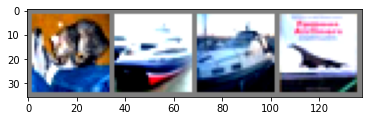

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
outputs = net(images)

tensor([[-5.3864, -5.4548, -1.9079, -1.2739, -2.0309, -1.4173, -2.3141, -2.6161,
         -6.1728, -4.1738],
        [-1.9744, -2.1065, -4.8772, -4.5565, -5.7550, -6.1556, -5.5919, -6.3141,
         -0.5404, -2.0555],
        [-1.5548, -2.8229, -3.0757, -2.9930, -2.6729, -3.3356, -6.4823, -1.9113,
         -2.1178, -1.3522],
        [-0.8323, -4.0232, -2.5705, -3.0089, -3.4061, -3.6405, -5.5004, -3.8747,
         -1.1967, -3.3583]], grad_fn=<LogSoftmaxBackward>)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship truck plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 40 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 40 %
Accuracy of   car : 36 %
Accuracy of  bird : 17 %
Accuracy of   cat : 32 %
Accuracy of  deer : 28 %
Accuracy of   dog : 29 %
Accuracy of  frog : 53 %
Accuracy of horse : 35 %
Accuracy of  ship : 67 %
Accuracy of truck : 67 %
